In [368]:
import os
from string import punctuation


from constants import label_index


import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, lit, concat, explode
from pyspark.ml.feature import (RegexTokenizer, 
                                StopWordsRemover, 
                                CountVectorizer,
                                OneHotEncoder,
                                StringIndexer,
                                VectorAssembler,
                                HashingTF,
                                IDF
                               )
                                
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn.metrics as sm

# Preprocessing

In [329]:
spark = SparkSession.builder \
    .appName("ArXiv Project")\
    .master("local[4]")\
    .getOrCreate()

In [330]:
# Regex patterns for collapsing subcategories into one category
physics_pattern = 'cond-mat.*|gr-qc|hep-ex|hep-lat|hep-ph|hep-th|nlin.*|nucl-ex|nucl-th|physics.*|quant-ph|acc-phys|plasm-ph|atom-ph|patt-sol|supr-con|mtrl-th|chao-dyn|comp-gas'
astro_pattern = 'astro-ph.*'
cs_pattern = 'cs.*|cmp-lg'
econ_pattern = 'econ.*'
electrical_eng_pattern = 'eess.*'
math_pattern = 'math.*|math-ph|alg-geom|bayes-an|q-alg|solv-int|dg-ga|funct-an'
bio_pattern = 'q-bio.*|ao-sci|chem-ph|adap-org'
finance_pattern = 'q-fin.*'
stat_pattern = 'stat.*' 

category_index = {
    'PHYS': physics_pattern,
    'ASTRO': astro_pattern,
    'CS': cs_pattern,
    'ECON': econ_pattern,
    'EESS': electrical_eng_pattern,
    'MATH': math_pattern,
    'BIO': bio_pattern,
    'FIN': finance_pattern,
    'STAT': stat_pattern
}

In [331]:
def unify_subcategories(df, category_index):
    """applies regex patterns to the subcategories column to unite the subcategories
    into their broader group category
    """
    # split categories cloumn into list of categories
    split_col  = pyspark.sql.functions.split(df['categories'], ' ')
    
    # grab first category and make column
    df = df.withColumn('category', split_col.getItem(0))
    
    for name, pattern in category_index.items():
        
        # collapse subcategories into broad category labels
        df = df.withColumn('category', pyspark.sql.functions.regexp_replace('category', pattern, name))
        
    # combine title and abstract into large text feature
    df = df.withColumn('text', lower(concat(col('title'), lit(' '), col('abstract'))))
    
    return df

In [332]:
# loading raw json data
path = './data/arxiv-metadata-oai-snapshot.json'

raw_data = spark.read.json(path)

# unify the subcategories and remove unneeded columns
data = unify_subcategories(raw_data, category_index)
data = data.select(['category', 'text'])

In [333]:
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# bag of words count
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

In [334]:
pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)
dataset.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+-----+
|category|                text|               words|            filtered|            features|label|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
|    PHYS|calculation of pr...|[calculation, of,...|[calculation, pro...|(10000,[4,13,16,2...|  0.0|
|    MATH|sparsity-certifyi...|[sparsity, certif...|[sparsity, certif...|(10000,[5,10,11,2...|  1.0|
|    PHYS|the evolution of ...|[the, evolution, ...|[evolution, earth...|(10000,[0,1,2,4,1...|  0.0|
|    MATH|a determinant of ...|[a, determinant, ...|[determinant, sti...|(10000,[8,84,193,...|  1.0|
|    MATH|from dyadic $\lam...|[from, dyadic, la...|[dyadic, lambda_,...|(10000,[6,7,8,12,...|  1.0|
+--------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



# Data Exploration

In [89]:
dataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+------+
|category| count|
+--------+------+
|    PHYS|863455|
|    MATH|436451|
|      CS|320574|
|   ASTRO|261725|
|    STAT| 35601|
|    EESS| 24893|
|     BIO| 23087|
|     FIN|  8838|
|    ECON|  3485|
+--------+------+



In [335]:
token_counts = dataset.withColumn('token', explode('filtered')).groupBy('token').count().sort('count', ascending=False)

In [321]:
top_tokens = token_counts.toPandas().iloc[:200]
top_tokens = top_tokens[top_tokens.token.apply(lambda x: len(x)>1)].iloc[:100]

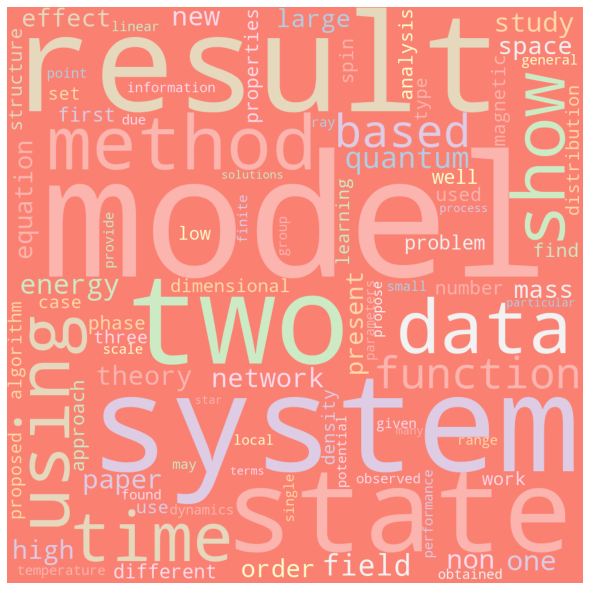

In [324]:
frame = top_tokens
frame = frame[frame.token.apply(lambda x: len(x)>1)]
frame['count'] = round(frame['count']/1000)
s = ''
for idx in range(frame.shape[0]):
    row = frame.iloc[idx]
    token = row['token']
    count = int(row['count'])
    for i in range(count):
        s += token + ' '
wordcloud = WordCloud(width= 1000, height = 1000, random_state=1, 
              background_color='salmon', colormap='Pastel1', 
              collocations=False).generate(s)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig(os.path.join('./plots/', f'topwords_wordcloud.png'))

In [336]:
# selecting the top 100 most common words to be removed
words_to_remove = top_tokens.iloc[:100].token.values

In [269]:
top_words_by_category = {}
top_words_by_category_dfs = {}

for category in category_index.keys():
    
    print(f'collecting word counts for: {category}')
    
    top = dataset.filter(dataset.category==category)\
                .withColumn('token', explode('refiltered')).groupBy('token').count().sort('count', ascending=False)
    
    top = top.toPandas().iloc[:100]
    
    top_words_by_category_dfs[category] = top
    
    top = top[top.token.apply(lambda x: len(x)>1)]
    
    top = top.token.tolist()
    
    word_counts[category] = top
    
print('finished.')

collecting word counts for: PHYS


collecting word counts for: ASTRO


collecting word counts for: CS


collecting word counts for: ECON


collecting word counts for: EESS


collecting word counts for: MATH


collecting word counts for: BIO


collecting word counts for: FIN


collecting word counts for: STAT


finished.


In [317]:
def generate_word_clouds(top_words_by_categories_df, categories_index, save_path):
    for category in categories_index.keys():
        print(f'building wordcloud for: {category}')
        frame = top_words_by_category_dfs[category]
        frame = frame[frame.token.apply(lambda x: len(x)>1)]
        frame['count'] = round(frame['count']/10)
        s = ''
        for idx in range(frame.shape[0]):
            row = frame.iloc[idx]
            token = row['token']
            count = int(row['count'])
            for i in range(count):
                s += token + ' '
        wordcloud = WordCloud(width= 1000, height = 1000, random_state=1, 
                      background_color='salmon', colormap='Pastel1', 
                      collocations=False).generate(s)
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.savefig(os.path.join(save_path, f'{category}_wordcloud.png'))

In [346]:
# generate_word_clouds(top_words_by_category_dfs, category_index, './plots/')

# Count Vector Experiment

In [339]:
(training_data, test_data) = dataset.randomSplit([0.7, 0.3], seed = 42)
print(f"Training Dataset Count: {training_data.count()}")
print(f"Training Dataset Count: {test_data.count()}")

Training Dataset Count: 1384667


Training Dataset Count: 593442


In [340]:
_, subset = training_data.randomSplit([0.7, 0.3], seed=42)
train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)
print(f"Training subset count: {train_subset.count()}")
print(f"Validation subset count: {valid_subset.count()}")

Training subset count: 290987


Validation subset count: 124484


In [341]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lr = lr.fit(train_subset)

In [343]:
predictions = lr.transform(valid_subset)

In [344]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")

MulticlassClassificationEvaluator_3de97bf504b1

In [345]:
evaluator.evaluate(predictions)

0.8673234291678606

### Count Vectors w/o most common

In [353]:
# loading raw json data
path = './data/arxiv-metadata-oai-snapshot.json'

raw_data = spark.read.json(path)

# unify the subcategories and remove unneeded columns
data = unify_subcategories(raw_data, category_index)
data = data.select(['category', 'text'])

# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(words_to_remove)

# bag of words count
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)

In [354]:
training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)
_, subset = training_data.randomSplit([0.7, 0.3], seed=42)
train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [355]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lr = lr.fit(train_subset)

predictions = lr.transform(valid_subset)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")

evaluator.evaluate(predictions)

0.8643940868529149

In [401]:
#####

In [402]:
# loading raw json data
path = './data/arxiv-metadata-oai-snapshot.json'

raw_data = spark.read.json(path)

# unify the subcategories and remove unneeded columns
data = unify_subcategories(raw_data, category_index)
data = data.select(['category', 'text'])

# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# bag of words count
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)

In [406]:
def under_sample(dataset, category_index, size=3485):
    frame = None
    for category in category_index:
        if not frame:
            frame = dataset.filter(dataset.category==category).limit(size)
        else:
            frame = frame.union(dataset.filter(dataset.category==category).limit(size))
    return frame

In [407]:
under_sampled_data = under_sample(dataset, category_index)

In [408]:
under_sampled_data.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|    PHYS| 3485|
|   ASTRO| 3485|
|      CS| 3485|
|    ECON| 3485|
|    EESS| 3485|
|    MATH| 3485|
|     BIO| 3485|
|     FIN| 3485|
|    STAT| 3485|
+--------+-----+



In [412]:
training_data, test_data = under_sampled_data.randomSplit([0.7, 0.3], seed = 42)
train_data, valid_data = training_data.randomSplit([0.7, 0.3], seed=42)

In [413]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lr = lr.fit(train_data)

predictions = lr.transform(valid_data)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")

evaluator.evaluate(predictions)

21/12/12 15:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1073.2 KiB


0.8278230484108978

In [414]:
valid_preds = predictions.select(['label','prediction']).toPandas()
report = sm.classification_report(valid_preds['label'], valid_preds['prediction'],target_names=pipeline.stages[-1].labels)

21/12/12 15:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1063.7 KiB


In [415]:
print(report)

              precision    recall  f1-score   support

        PHYS       0.84      0.83      0.83       692
        MATH       0.79      0.90      0.84       731
          CS       0.77      0.72      0.74       755
       ASTRO       0.97      0.91      0.94       728
        STAT       0.74      0.77      0.75       734
        EESS       0.86      0.83      0.84       738
         BIO       0.86      0.84      0.85       726
         FIN       0.85      0.85      0.85       719
        ECON       0.80      0.81      0.80       686

    accuracy                           0.83      6509
   macro avg       0.83      0.83      0.83      6509
weighted avg       0.83      0.83      0.83      6509



# TFIDF Experiment

In [94]:
# predictions.select(['category', 'label', 'prediction', 'probability']).tail(10)

In [107]:
term_freq_hasher = HashingTF(inputCol="words", outputCol="raw_features", numFeatures=10000)

idf = IDF(inputCol="raw_features", outputCol="features", minDocFreq=5) 

pipeline = Pipeline(stages=[tokenizer, term_freq_hasher, idf, label_indexer])

pipeline = pipeline.fit(data)

dataset = pipeline.transform(data)

(training_data, test_data) = dataset.randomSplit([0.7, 0.3], seed = 42)

_, subset = training_data.randomSplit([0.7, 0.3], seed=42)

train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [109]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

lr = lr.fit(train_subset)

predictions = lr.transform(valid_subset)

In [110]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8547437274097942

# Naive Bayes Experiment

In [120]:
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# bag of words count
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

In [121]:
pipeline = Pipeline(stages=[tokenizer, count_vectorizer, label_indexer])

pipeline = pipeline.fit(data)

dataset = pipeline.transform(data)

training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)

_, subset = training_data.randomSplit([0.7, 0.3], seed=42)

train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [122]:
nb = NaiveBayes(smoothing=1)
nb = nb.fit(train_subset)

In [123]:
predictions = nb.transform(valid_subset)

In [124]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.847870880775229

In [357]:
# loading raw json data
path = './data/arxiv-metadata-oai-snapshot.json'

raw_data = spark.read.json(path)

# unify the subcategories and remove unneeded columns
data = unify_subcategories(raw_data, category_index)
data = data.select(['category', 'text'])

# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(words_to_remove)

# bag of words count
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)

training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)
_, subset = training_data.randomSplit([0.7, 0.3], seed=42)
train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [358]:
nb = NaiveBayes(smoothing=1)
nb = nb.fit(train_subset)

predictions = nb.transform(valid_subset)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")
evaluator.evaluate(predictions)

0.8460820345672351

# Random Forest Experiment

In [115]:
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# bag of words count
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

In [116]:
pipeline = Pipeline(stages=[tokenizer, count_vectorizer, label_indexer])

pipeline = pipeline.fit(data)

dataset = pipeline.transform(data)

training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)

_, subset = training_data.randomSplit([0.7, 0.3], seed=42)

train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [149]:
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)


rf = rf.fit(train_subset)

predictions = rf.transform(valid_subset)

In [119]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.30067328498160645

# Hyperparameter Search

In [127]:
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# bag of words count
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

In [128]:
pipeline = Pipeline(stages=[tokenizer, count_vectorizer, label_indexer])

pipeline = pipeline.fit(data)

dataset = pipeline.transform(data)

training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)

_, subset = training_data.randomSplit([0.7, 0.3], seed=42)

train_subset, valid_subset = subset.randomSplit([0.7, 0.3], seed=42)

In [150]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

param_grid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
             .addGrid(lr.maxIter, [10, 20, 50]) #Number of iterations
             .build())

cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=param_grid, \
                    evaluator=evaluator, \
                    numFolds=5)

cv = cv.fit(train_subset)

In [130]:
predictions = cv.transform(valid_subset)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8824951107336056

In [140]:
best_model = cv.bestModel

In [148]:
print(f"Best regularization param: {best_model.getRegParam()}")
print(f"Best elastic net param: {best_model.getElasticNetParam()}")
print(f"Best max iter: {best_model.getMaxIter()}")

Best regularization param: 0.1
Best elastic net param: 0.0
Best max iter: 50


# Learning Curve Experiment

In [153]:
# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")
# bag of words count
count_vectorizer = CountVectorizer(inputCol="words", outputCol="features", vocabSize=10000, minDF=5)
##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

In [154]:
pipeline = Pipeline(stages=[tokenizer, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)

In [160]:
train_data, valid_data = training_data.randomSplit([0.95, 0.05], seed=42)

## Small

In [162]:
_, train_subset = train_data.randomSplit([0.7, 0.3], seed=42)
print(f"Training subset count: {train_subset.count()}")

Training subset count: 394353


In [181]:
lr = LogisticRegression(maxIter=50, regParam=0.1, elasticNetParam=0)
lr = lr.fit(train_subset)

In [166]:
predictions = lr.transform(valid_subset)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

0.8854572662981226

## Medium

In [167]:
_, train_subset = train_data.randomSplit([0.4, 0.6], seed=42)
print(f"Training subset count: {train_subset.count()}")

Training subset count: 788727


In [180]:
lr = LogisticRegression(maxIter=50, regParam=0.1, elasticNetParam=0)
lr = lr.fit(train_subset)

In [169]:
predictions = lr.transform(valid_subset)

0.8862211457835156

In [171]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")
evaluator.evaluate(predictions)

0.8862211457835156

# Full training dataset

In [424]:
# loading raw json data
path = './data/arxiv-metadata-oai-snapshot.json'

raw_data = spark.read.json(path)

# unify the subcategories and remove unneeded columns
data = unify_subcategories(raw_data, category_index)
data = data.select(['category', 'text'])

# regular expression tokenizer
tokenizer = RegexTokenizer(inputCol="text", outputCol="words", pattern="\\W")

# remove stopwords
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# bag of words count
count_vectorizer = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

##
label_indexer = StringIndexer(inputCol="category", outputCol="label")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, count_vectorizer, label_indexer])
# Fit the pipeline to training documents.
pipeline = pipeline.fit(data)
dataset = pipeline.transform(data)

training_data, test_data = dataset.randomSplit([0.7, 0.3], seed = 42)
train_data, valid_data = training_data.randomSplit([0.7, 0.3], seed=42)

In [425]:
lr = LogisticRegression(maxIter=50, regParam=0.1, elasticNetParam=0)
lr = lr.fit(train_data)

predictions = lr.transform(valid_data)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")
evaluator.evaluate(predictions)

21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_3 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_4 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_6 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_5 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_7 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_10 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_8 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:21 WARN MemoryStore: Not enough space to cache rdd_25451_11 in memory! (computed 17.0 MiB so far)
21/12/12 17:11:22 WARN MemoryStore: Not enough space to cache rdd_25451_12 in memory! (computed 17.0 M

0.8842780944691959

In [426]:
valid_predictions = predictions.select(['label','prediction']).toPandas()
# valid_predictions[['label','prediction']].to_csv('./predictions/valid_predictions.txt')
report = sm.classification_report(valid_predictions['label'], valid_predictions['prediction'],target_names=pipeline.stages[-1].labels)

In [427]:
print(report)

              precision    recall  f1-score   support

        PHYS       0.91      0.95      0.93    181614
        MATH       0.88      0.91      0.89     91576
          CS       0.83      0.88      0.85     67249
       ASTRO       0.96      0.89      0.93     54919
        STAT       0.69      0.39      0.49      7479
        EESS       0.52      0.11      0.18      5340
         BIO       0.72      0.38      0.50      4748
         FIN       0.72      0.40      0.51      1833
        ECON       0.55      0.03      0.06       713

    accuracy                           0.89    415471
   macro avg       0.75      0.55      0.59    415471
weighted avg       0.89      0.89      0.88    415471



# Testing

In [178]:
print(f"Testing count: {test_data.count()}")

Testing count: 593442


In [428]:
test_predictions = lr.transform(test_data)

evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.setMetricName("f1")
evaluator.evaluate(test_predictions)

0.8839602900374538

In [429]:
test_preds = test_predictions.select(['label','prediction']).toPandas()

In [430]:
# test_preds[['label','prediction']].to_csv('./predictions/test_predictions.txt')

In [431]:
report = sm.classification_report(test_preds['label'], test_preds['prediction'],target_names=pipeline.stages[-1].labels)

In [432]:
print(report)

              precision    recall  f1-score   support

        PHYS       0.91      0.95      0.93    258901
        MATH       0.88      0.91      0.89    131055
          CS       0.83      0.88      0.85     96214
       ASTRO       0.96      0.89      0.93     78245
        STAT       0.69      0.39      0.50     10877
        EESS       0.55      0.12      0.20      7521
         BIO       0.71      0.37      0.48      6934
         FIN       0.72      0.39      0.50      2647
        ECON       0.45      0.02      0.05      1048

    accuracy                           0.89    593442
   macro avg       0.75      0.55      0.59    593442
weighted avg       0.89      0.89      0.88    593442

